In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random as rd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
import graphviz 
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from scipy.stats import f_oneway
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor

In [61]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [62]:
file_path = "C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/cleaned_data.csv"

property_df = pd.read_csv(file_path)
print(property_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  property_type           5147 non-null   object 
 14  propsubtype             5147 non-null   

In [63]:
property_df["saleAmt"].isna().sum()

0

### Analysis on Numerical Columns

In [64]:
num_cols = property_df.columns[property_df.dtypes != 'object']
num_cols

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'saleAmt'], dtype='object')

<AxesSubplot:>

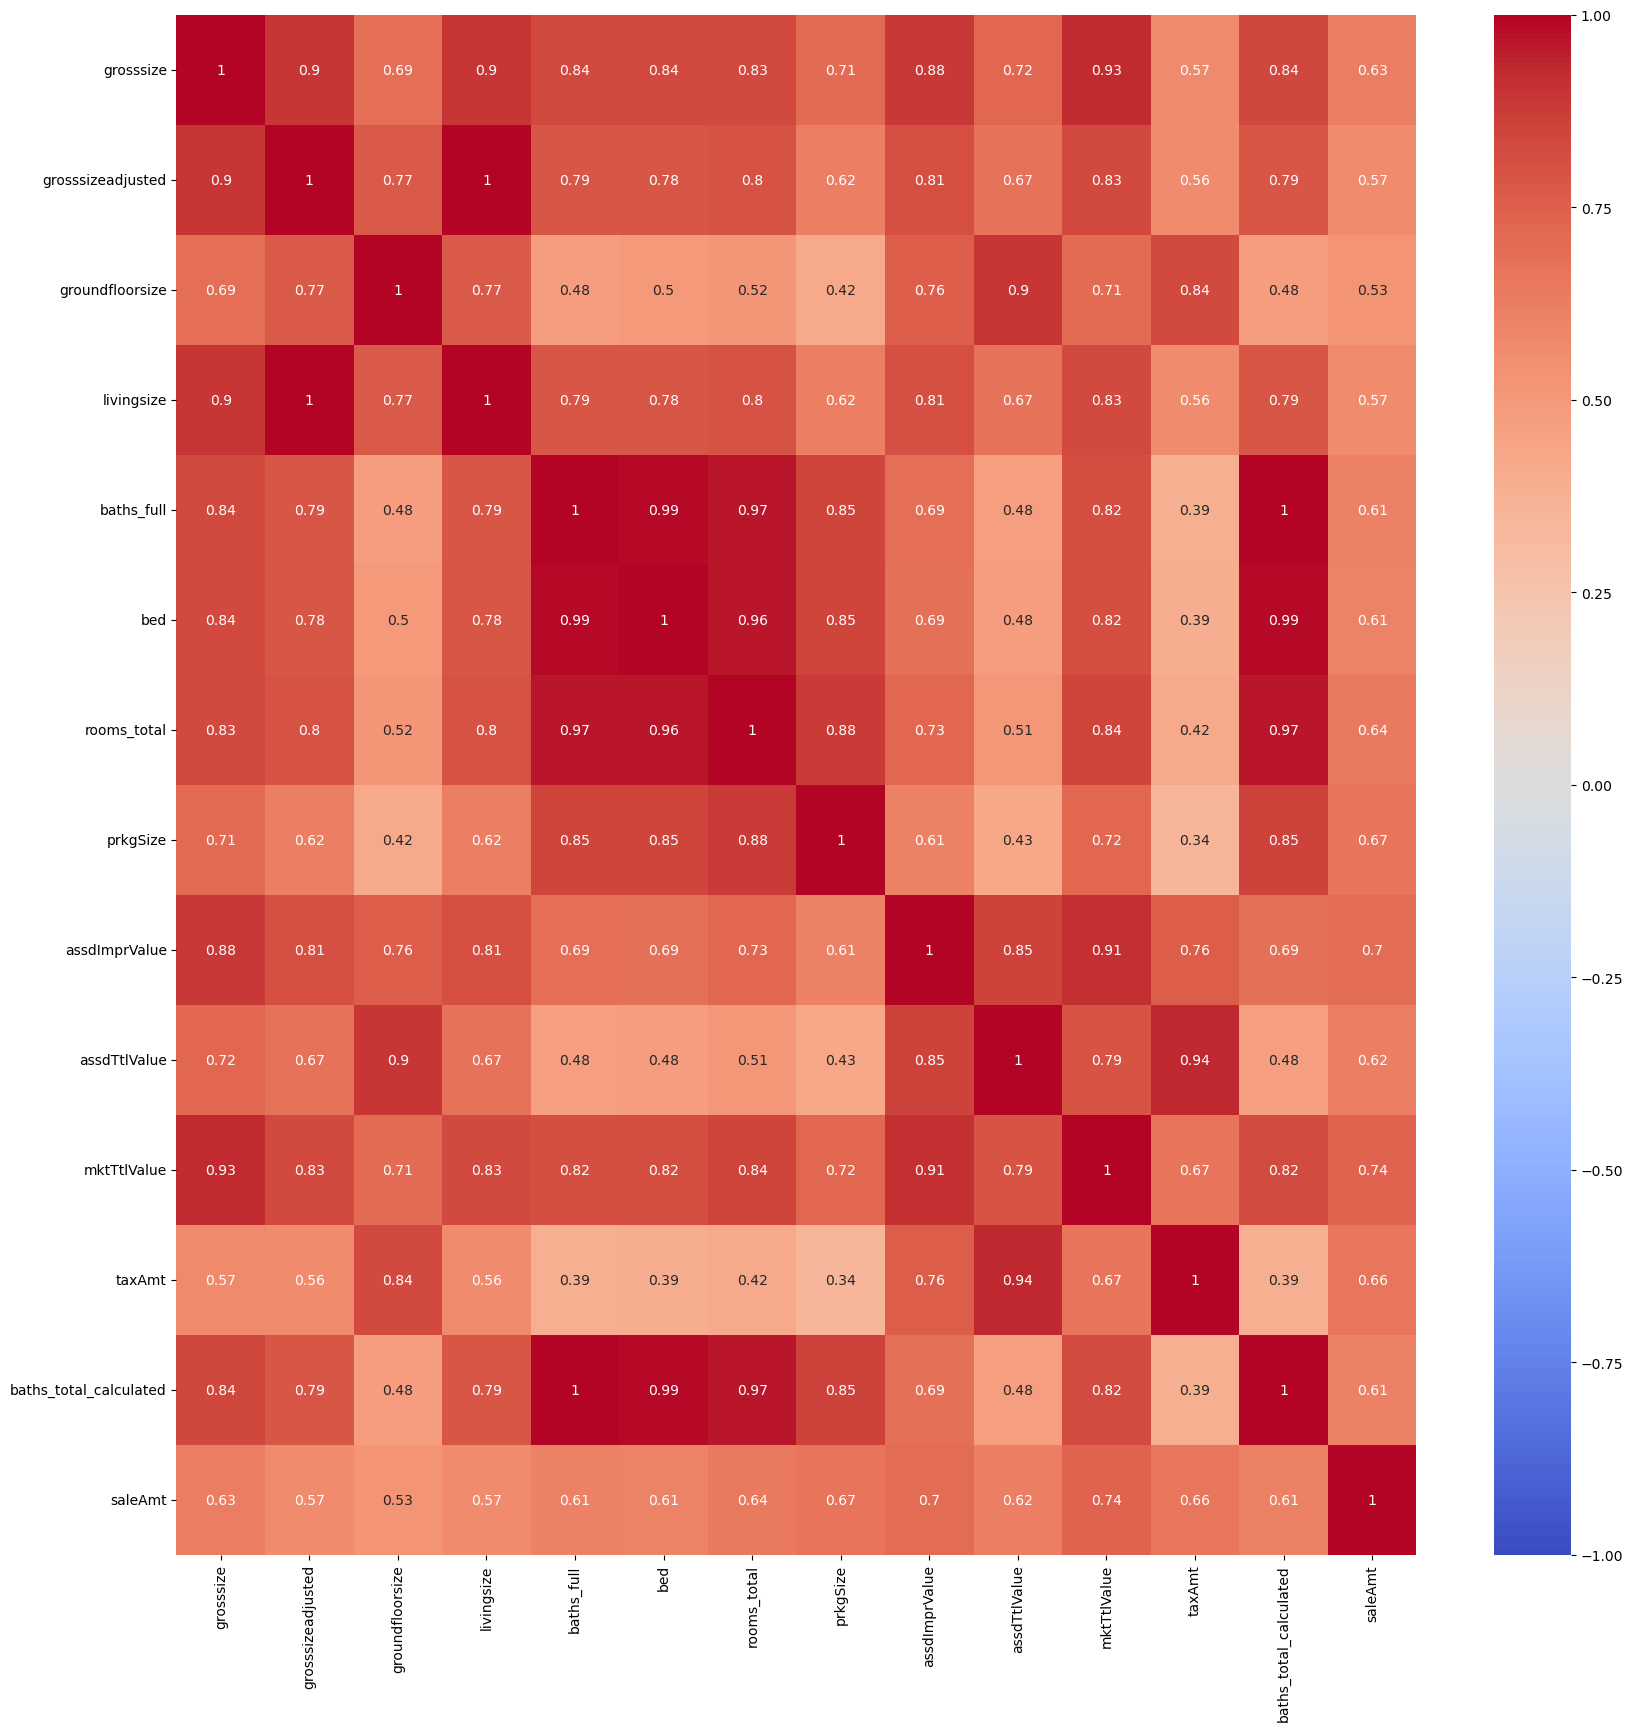

In [65]:
num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df[num_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

### Analysis on Categorical Columns

In [66]:
property_df.describe(include='O')

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
unique,30,7,29,10,6,12,2930,5,11,5,6,4
top,SINGLE FAMILY RESIDENCE,RESIDENTIAL,SFR,FORCED AIR,CENTRAL,BRICK VENEER,2005-03-04,AVERAGE,FRAME,WOOD,"Garage, Attached",CONVENTIONAL HOUSE
freq,2479,4978,2556,4239,2835,2421,33,2674,3195,3267,3361,2981


#### Convert Required Categorical Columns to Numerical Columns for Clustering

In [67]:
data = property_df

# Define a significance level (alpha) for the ANOVA test
alpha = 0.05

# Initialize a list to store columns with significant dependency
significant_cols = []

# Iterate through categorical columns
categorical_columns = data.columns[property_df.dtypes == 'object']
# categorical_columns = ['property_type', 'absenteeInd', 'heatingtype', 'coolingtype', 'wallType', 'saleTransType', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType']

for column in categorical_columns:
    # Perform ANOVA test for independence
    groups = [data[data[column] == category]['saleAmt'] for category in data[column].unique()]
    f_statistic, p_value = f_oneway(*groups)
    
    # Check if the p-value is less than alpha (indicating significant dependency)
    if p_value < alpha:
        significant_cols.append(column)

# Select only the significant columns from the dataset
data_filtered = data[significant_cols + ['saleAmt']]

# Perform target encoding for the selected columns
encoder = ce.TargetEncoder()
data_encoded = encoder.fit_transform(data_filtered.drop('saleAmt', axis=1), data_filtered['saleAmt'])

# Combine the encoded data with the original 'saleAmt' column
property_df_encoded = pd.concat([data_encoded, data_filtered['saleAmt']], axis=1)

property_df_encoded.head(5)

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmt
0,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,713242.190135,6.061591e+05,685772.730203,741104.830425,603424.419521,2.399808e+06,501930.0
1,393683.553323,691279.568903,393683.553323,677479.963671,701893.005226,828838.765778,676663.905204,6.061591e+05,685772.730203,741104.830425,786176.916989,6.092664e+05,179350.0
2,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,792087.341937,7.907225e+05,685772.730203,741104.830425,786176.916989,7.643636e+05,1900000.0
3,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,832184.472070,6.061591e+05,744620.611224,744620.611224,786176.916989,7.643636e+05,1100000.0
4,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,751763.406140,1.201011e+06,744620.611224,744620.611224,786176.916989,7.643636e+05,798000.0


In [68]:
# Drop categorical columns in property_df
property_df = property_df.select_dtypes(exclude=['object'])

# Merge the encoded categorical columns data to property_df
property_df = pd.concat([property_df, property_df_encoded.drop('saleAmt', axis=1)], axis=1)
property_df.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5.147000e+03
mean,2909.412862,1982.077132,1647.700818,1982.077132,2.071304,3.543423,7.492326,495.264846,4.645036e+04,7.128977e+04,8.490291e+05,6541.914312,2.944822,7.448479e+05,6.912288e+05,7.392740e+05,6.912433e+05,7.417029e+05,7.399729e+05,7.379896e+05,7.480519e+05,7.448770e+05,7.309487e+05,7.403743e+05,744761.478359,7.450742e+05
std,8699.439421,5067.840521,4284.518558,5067.840521,13.268863,13.558907,24.028648,1172.644111,1.561694e+05,2.439678e+05,2.115490e+06,21363.092294,13.268904,2.353568e+06,7.706794e+05,2.981515e+05,7.701445e+05,3.000136e+05,2.531116e+05,1.853134e+05,2.866732e+05,2.363256e+05,2.549569e+05,7.295949e+04,118516.285610,2.788011e+05
min,90.000000,90.000000,8.000000,90.000000,0.000000,1.000000,1.000000,86.000000,2.900000e+02,3.430000e+02,1.300000e+03,33.840000,0.000000,5.000000e+02,3.936836e+05,6.912796e+05,3.936836e+05,5.515735e+05,7.018930e+05,5.245341e+05,5.162916e+05,6.061591e+05,6.097213e+05,6.275322e+05,392588.149215,6.092664e+05
25%,1027.500000,970.000000,857.000000,970.000000,1.000000,2.000000,5.000000,260.000000,1.972400e+04,2.889500e+04,4.086000e+05,2713.380000,2.000000,3.290000e+05,3.936836e+05,6.912796e+05,3.936836e+05,6.774800e+05,7.018930e+05,5.245341e+05,6.920765e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,6.092664e+05
50%,1938.000000,1312.000000,1121.000000,1312.000000,1.000000,3.000000,6.000000,480.000000,2.725100e+04,4.545300e+04,6.459000e+05,4257.880000,2.000000,4.980000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.288388e+05,7.159185e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,7.643636e+05
75%,3214.500000,2006.500000,1592.000000,2006.500000,2.000000,4.000000,8.000000,506.000000,3.926400e+04,6.301250e+04,8.931500e+05,5956.320000,3.000000,7.600000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.504536e+05,7.502952e+05,7.907225e+05,7.446206e+05,7.446206e+05,786176.916989,7.643636e+05
max,362967.000000,165530.000000,172081.000000,165530.000000,518.000000,518.000000,966.000000,50626.000000,5.077697e+06,1.120128e+07,7.809005e+07,982413.360000,518.000000,1.042500e+08,9.974938e+06,3.182450e+06,9.974938e+06,2.836450e+06,2.599094e+06,2.113130e+06,1.421175e+07,1.968083e+06,3.231621e+06,1.590885e+06,869456.297873,2.399808e+06


In [69]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

### Normalize Data

In [70]:
scaler = MinMaxScaler()

property_df_normalized = scaler.fit_transform(property_df)
property_df_normalized = pd.DataFrame(property_df_normalized, columns=property_df.columns)

property_df_normalized.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,0.007770,0.011437,0.009529,0.011437,0.003999,0.004920,0.006728,0.008098,0.009091,0.006334,0.010856,0.006625,0.005685,0.007140,0.031055,0.019266,0.031056,0.083212,0.020072,0.134367,0.016922,0.101854,0.046236,0.117135,0.738513,0.075847
std,0.023974,0.030632,0.024899,0.030632,0.025616,0.026226,0.024900,0.023202,0.030758,0.021781,0.027091,0.021746,0.025616,0.022576,0.080436,0.119683,0.080380,0.131304,0.133413,0.116652,0.020932,0.173523,0.097241,0.075735,0.248531,0.155708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002584,0.005319,0.004934,0.005319,0.001931,0.001934,0.004145,0.003443,0.003828,0.002549,0.005216,0.002728,0.003861,0.003151,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012835,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005093,0.007386,0.006468,0.007386,0.001931,0.003868,0.005181,0.007796,0.005310,0.004027,0.008255,0.004300,0.003861,0.004772,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014576,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008610,0.011584,0.009205,0.011584,0.003861,0.005803,0.007254,0.008310,0.007676,0.005595,0.011421,0.006029,0.005792,0.007285,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017086,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662


In [72]:
property_df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

In [73]:
min_sale_amt = property_df_normalized["saleAmt"].min()
max_sale_amt = property_df_normalized["saleAmt"].max()

print("Minimum saleAmt:", min_sale_amt)
print("Maximum saleAmt:", max_sale_amt)

Minimum saleAmt: 0.0
Maximum saleAmt: 0.9999999999999999


In [74]:
property_df_normalized["saleAmt"].isna().sum()

0

In [75]:
property_df_normalized["saleAmt"].describe()

count    5147.000000
mean        0.007140
std         0.022576
min         0.000000
25%         0.003151
50%         0.004772
75%         0.007285
max         1.000000
Name: saleAmt, dtype: float64

In [76]:
bins = [-1, 0.003151, 0.004772, 0.007285, 1]
labels = ['Economical Price', 'Budget-Friendly Price', 'Standard Price', 'Premium Price']

property_df_normalized['saleAmtCategory'] = pd.cut(property_df_normalized['saleAmt'], bins=bins, labels=labels)

In [77]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmtCategory
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000,Standard Price
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000,Economical Price
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662,Premium Price
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662,Premium Price
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662,Premium Price


In [78]:
property_df_normalized["saleAmtCategory"].isna().sum()

0

In [81]:
property_df_normalized.to_csv("C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/property_data_supervised.csv", mode='w', index=False)

### Decision Trees

In [21]:
y = property_df_normalized["saleAmtCategory"]
X = property_df_normalized.drop(['saleAmt', 'saleAmtCategory'], axis = 1)

X.columns

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'property_type', 'propsubtype', 'proptype', 'heatingtype', 'coolingtype', 'wallType', 'saleRecDate', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType'], dtype='object')

In [22]:
y.isna().sum()

0

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
y_train.value_counts()

Standard Price           1062
Budget-Friendly Price    1037
Premium Price            1014
Economical Price         1004
Name: saleAmtCategory, dtype: int64

In [25]:
DT1 = DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                             splitter='best',  ## or "random" or "best"
                             max_depth=3, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             random_state=None, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             class_weight=None)

DT1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [26]:
feature_names = X_train.columns

In [27]:
class_names = y_train.unique()

[Text(0.5, 0.875, 'saleRecDate <= 0.014\nentropy = 2.0\nsamples = 4117\nvalue = [1037, 1004, 1014, 1062]\nclass = Premium Price'),
 Text(0.25, 0.625, 'saleRecDate <= 0.013\nentropy = 1.548\nsamples = 1924\nvalue = [743, 881, 37, 263]\nclass = Budget-Friendly Price'),
 Text(0.125, 0.375, 'mktTtlValue <= 0.008\nentropy = 0.932\nsamples = 950\nvalue = [148, 748, 1, 53]\nclass = Budget-Friendly Price'),
 Text(0.0625, 0.125, 'entropy = 0.434\nsamples = 741\nvalue = [52, 683, 0, 6]\nclass = Budget-Friendly Price'),
 Text(0.1875, 0.125, 'entropy = 1.561\nsamples = 209\nvalue = [96, 65, 1, 47]\nclass = Standard Price'),
 Text(0.375, 0.375, 'mktTtlValue <= 0.008\nentropy = 1.48\nsamples = 974\nvalue = [595, 133, 36, 210]\nclass = Standard Price'),
 Text(0.3125, 0.125, 'entropy = 1.284\nsamples = 468\nvalue = [296, 128, 3, 41]\nclass = Standard Price'),
 Text(0.4375, 0.125, 'entropy = 1.3\nsamples = 506\nvalue = [299, 5, 33, 169]\nclass = Standard Price'),
 Text(0.75, 0.625, 'grosssize <= 0.003\

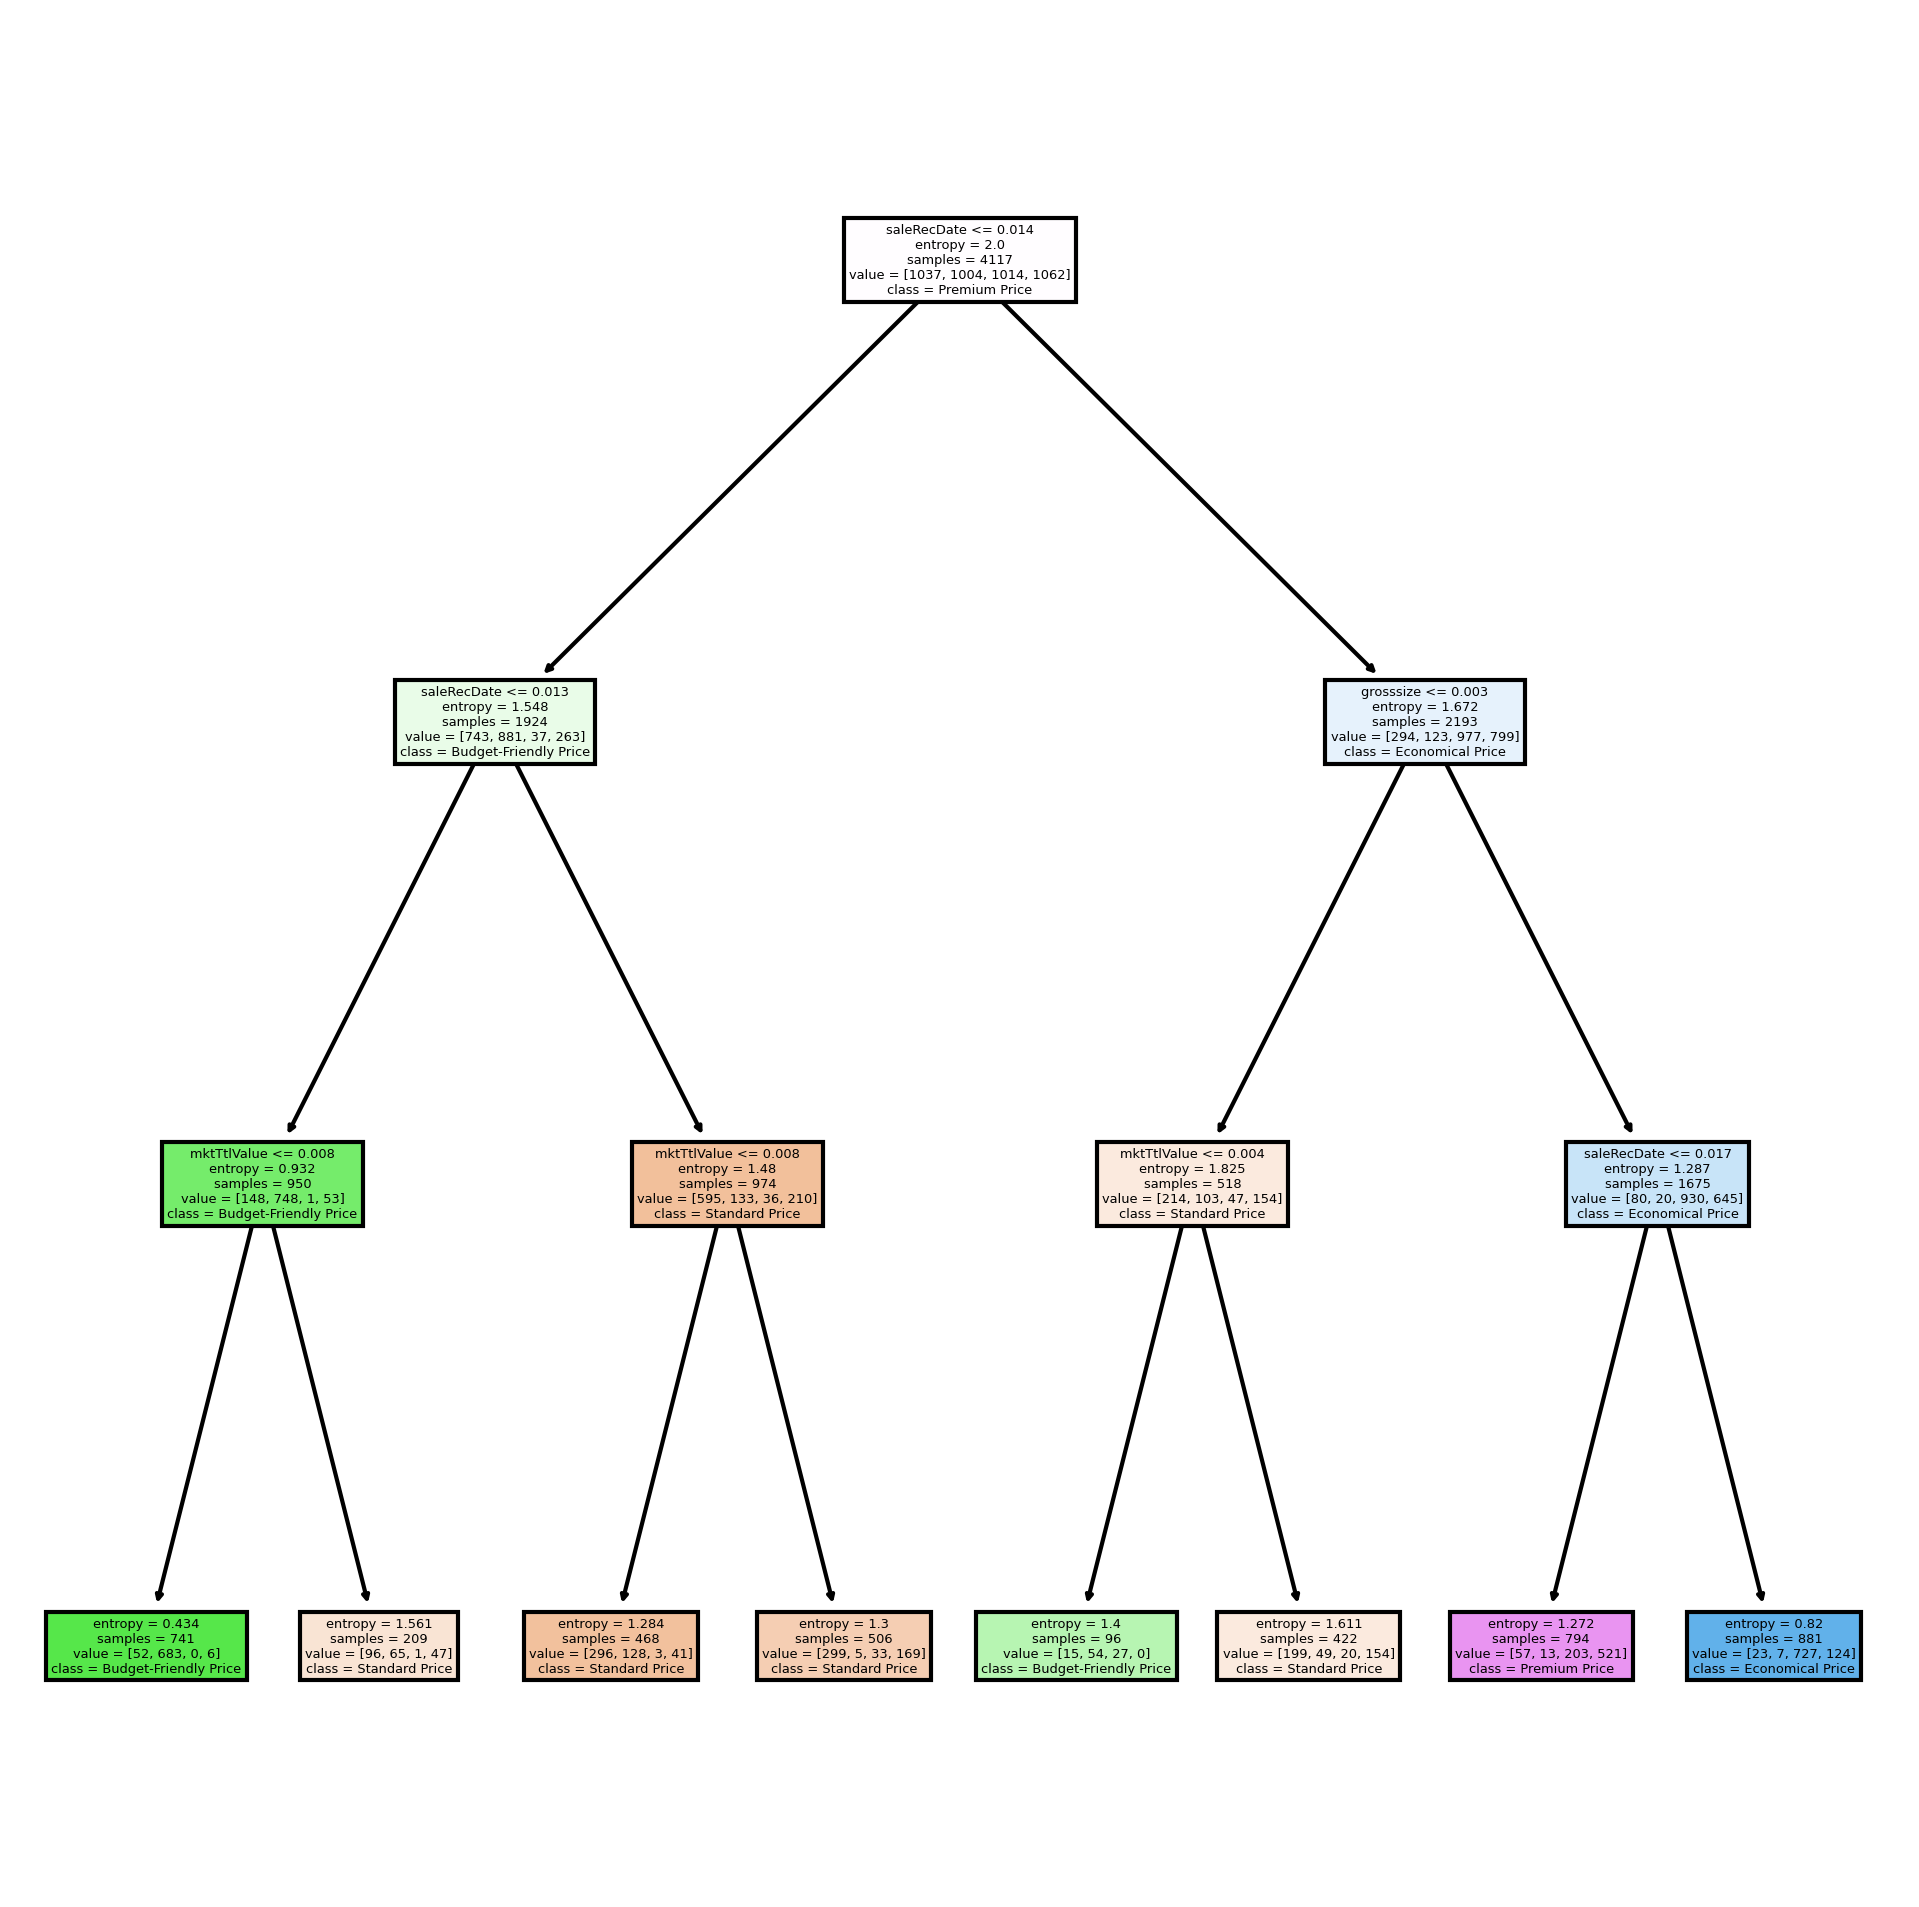

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 8), dpi=300)
plot_tree(DT1, filled=True, feature_names=feature_names, class_names=class_names, impurity=True, ax=axes)

In [31]:
# Use the classifier to make predictions on the testing data
y_pred = DT1.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[208  25   4  12]
 [ 83 190   3   5]
 [  7  10 199  60]
 [ 85   2  30 107]]


Text(0.5, 1.0, 'Confusion Matrix')

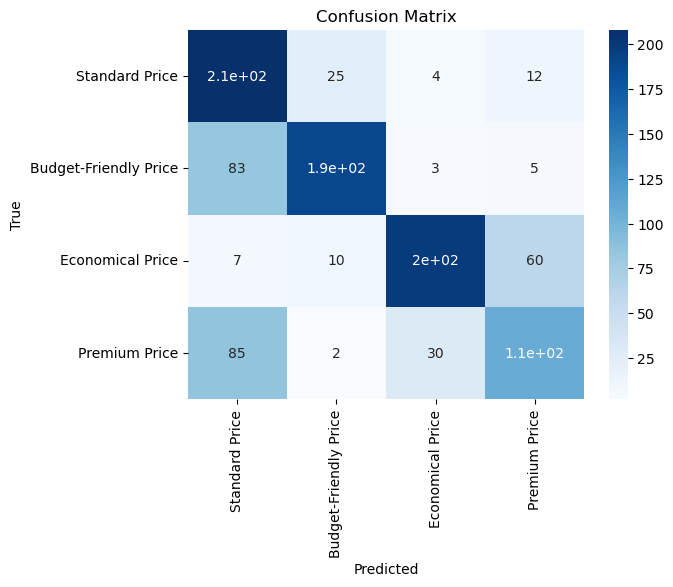

In [32]:
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of tree with entropy as criterion is: " + str(accuracy))

Accuracy of tree with entropy as criterion is: 0.683495145631068


In [34]:
DT2 = DecisionTreeClassifier(criterion='gini', ##"entropy" or "gini"
                             splitter='best',  ## or "random" or "best"
                             max_depth=3, 
                             min_samples_split=2, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=None, 
                             random_state=None, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             class_weight=None)

In [35]:
DT2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

[Text(0.5, 0.875, 'saleRecDate <= 0.013\ngini = 0.75\nsamples = 4117\nvalue = [1037, 1004, 1014, 1062]\nclass = Premium Price'),
 Text(0.25, 0.625, 'mktTtlValue <= 0.008\ngini = 0.356\nsamples = 958\nvalue = [150, 752, 3, 53]\nclass = Budget-Friendly Price'),
 Text(0.125, 0.375, 'saleRecDate <= 0.012\ngini = 0.145\nsamples = 745\nvalue = [52, 687, 0, 6]\nclass = Budget-Friendly Price'),
 Text(0.0625, 0.125, 'gini = 0.059\nsamples = 527\nvalue = [14, 511, 0, 2]\nclass = Budget-Friendly Price'),
 Text(0.1875, 0.125, 'gini = 0.317\nsamples = 218\nvalue = [38, 176, 0, 4]\nclass = Budget-Friendly Price'),
 Text(0.375, 0.375, 'assdTtlValue <= 0.005\ngini = 0.646\nsamples = 213\nvalue = [98, 65, 3, 47]\nclass = Standard Price'),
 Text(0.3125, 0.125, 'gini = 0.569\nsamples = 139\nvalue = [77, 47, 1, 14]\nclass = Standard Price'),
 Text(0.4375, 0.125, 'gini = 0.661\nsamples = 74\nvalue = [21, 18, 2, 33]\nclass = Premium Price'),
 Text(0.75, 0.625, 'saleRecDate <= 0.017\ngini = 0.71\nsamples = 3

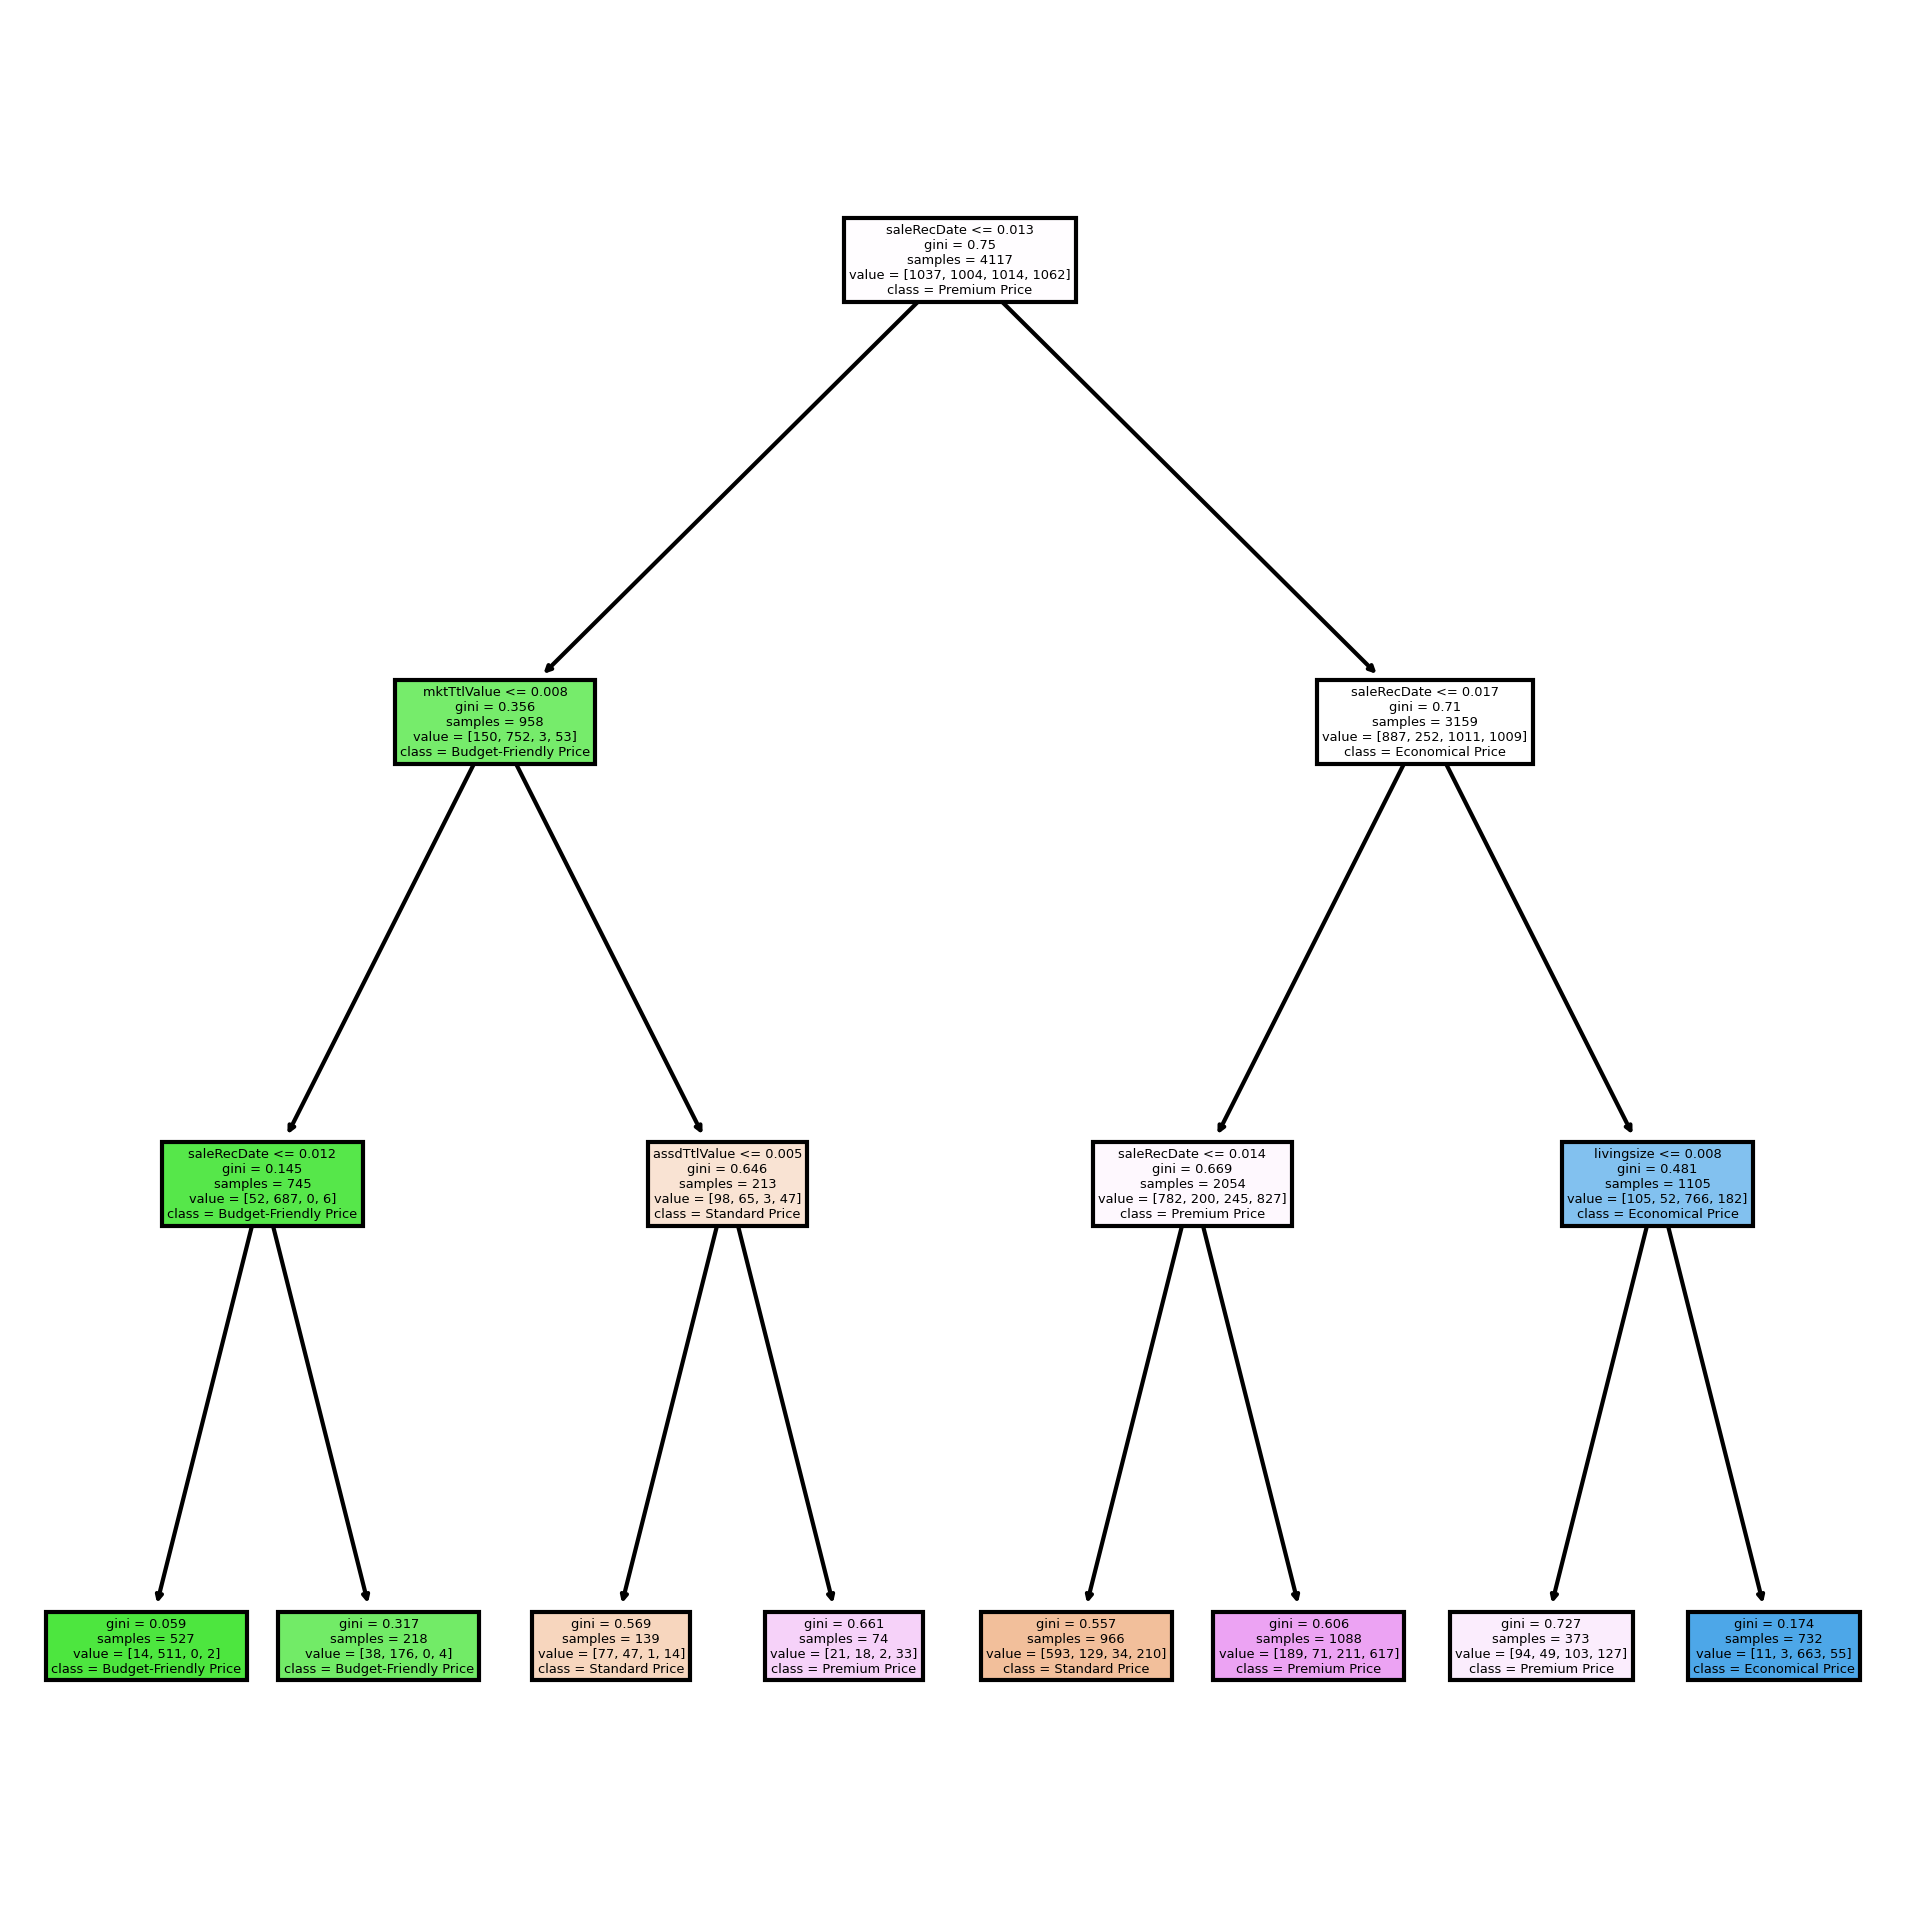

In [36]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 8), dpi=300)
plot_tree(DT2, filled=True, feature_names=feature_names, class_names=class_names, impurity=True, ax=axes)

[[162  20   1  66]
 [ 63 176   1  41]
 [  5   0 169 102]
 [ 40   1  18 165]]
Accuracy of tree with gini as criterion is: 0.6524271844660194


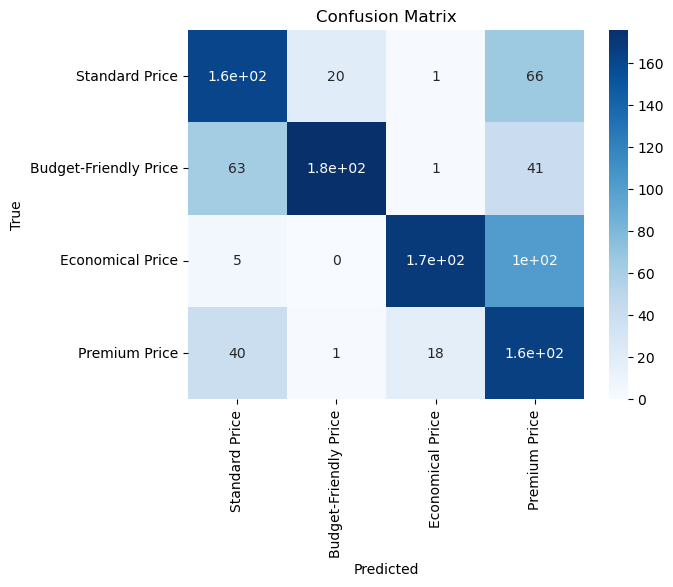

In [37]:
# Use the classifier to make predictions on the testing data
y_pred_2 = DT2.predict(X_test)

# Get the confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2)
print(cm_2)
# Print the confusion matrix

sns.heatmap(cm_2, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Get and Print the accuracy
accuracy_2 = accuracy_score(y_test, y_pred_2)
print("Accuracy of tree with gini as criterion is: " + str(accuracy_2))

In [38]:
DT3 = DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                             splitter='best',  ## or "random" or "best"
                             max_depth=3, 
                             min_samples_split=3, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features=4, 
                             random_state=None, 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             class_weight=None)

In [39]:
DT3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=4,
                       min_samples_leaf=2, min_samples_split=3)

[Text(0.5, 0.875, 'bldgType <= 0.065\nentropy = 2.0\nsamples = 4117\nvalue = [1037, 1004, 1014, 1062]\nclass = Premium Price'),
 Text(0.25, 0.625, 'taxAmt <= 0.003\nentropy = 1.79\nsamples = 1619\nvalue = [475, 722, 152, 270]\nclass = Budget-Friendly Price'),
 Text(0.125, 0.375, 'livingsize <= 0.002\nentropy = 1.244\nsamples = 998\nvalue = [298, 638, 27, 35]\nclass = Budget-Friendly Price'),
 Text(0.0625, 0.125, 'entropy = 0.605\nsamples = 27\nvalue = [0, 4, 23, 0]\nclass = Economical Price'),
 Text(0.1875, 0.125, 'entropy = 1.13\nsamples = 971\nvalue = [298, 634, 4, 35]\nclass = Budget-Friendly Price'),
 Text(0.375, 0.375, 'assdTtlValue <= 0.004\nentropy = 1.903\nsamples = 621\nvalue = [177, 84, 125, 235]\nclass = Premium Price'),
 Text(0.3125, 0.125, 'entropy = 1.693\nsamples = 381\nvalue = [141, 81, 12, 147]\nclass = Premium Price'),
 Text(0.4375, 0.125, 'entropy = 1.532\nsamples = 240\nvalue = [36, 3, 113, 88]\nclass = Economical Price'),
 Text(0.75, 0.625, 'mktTtlValue <= 0.01\nen

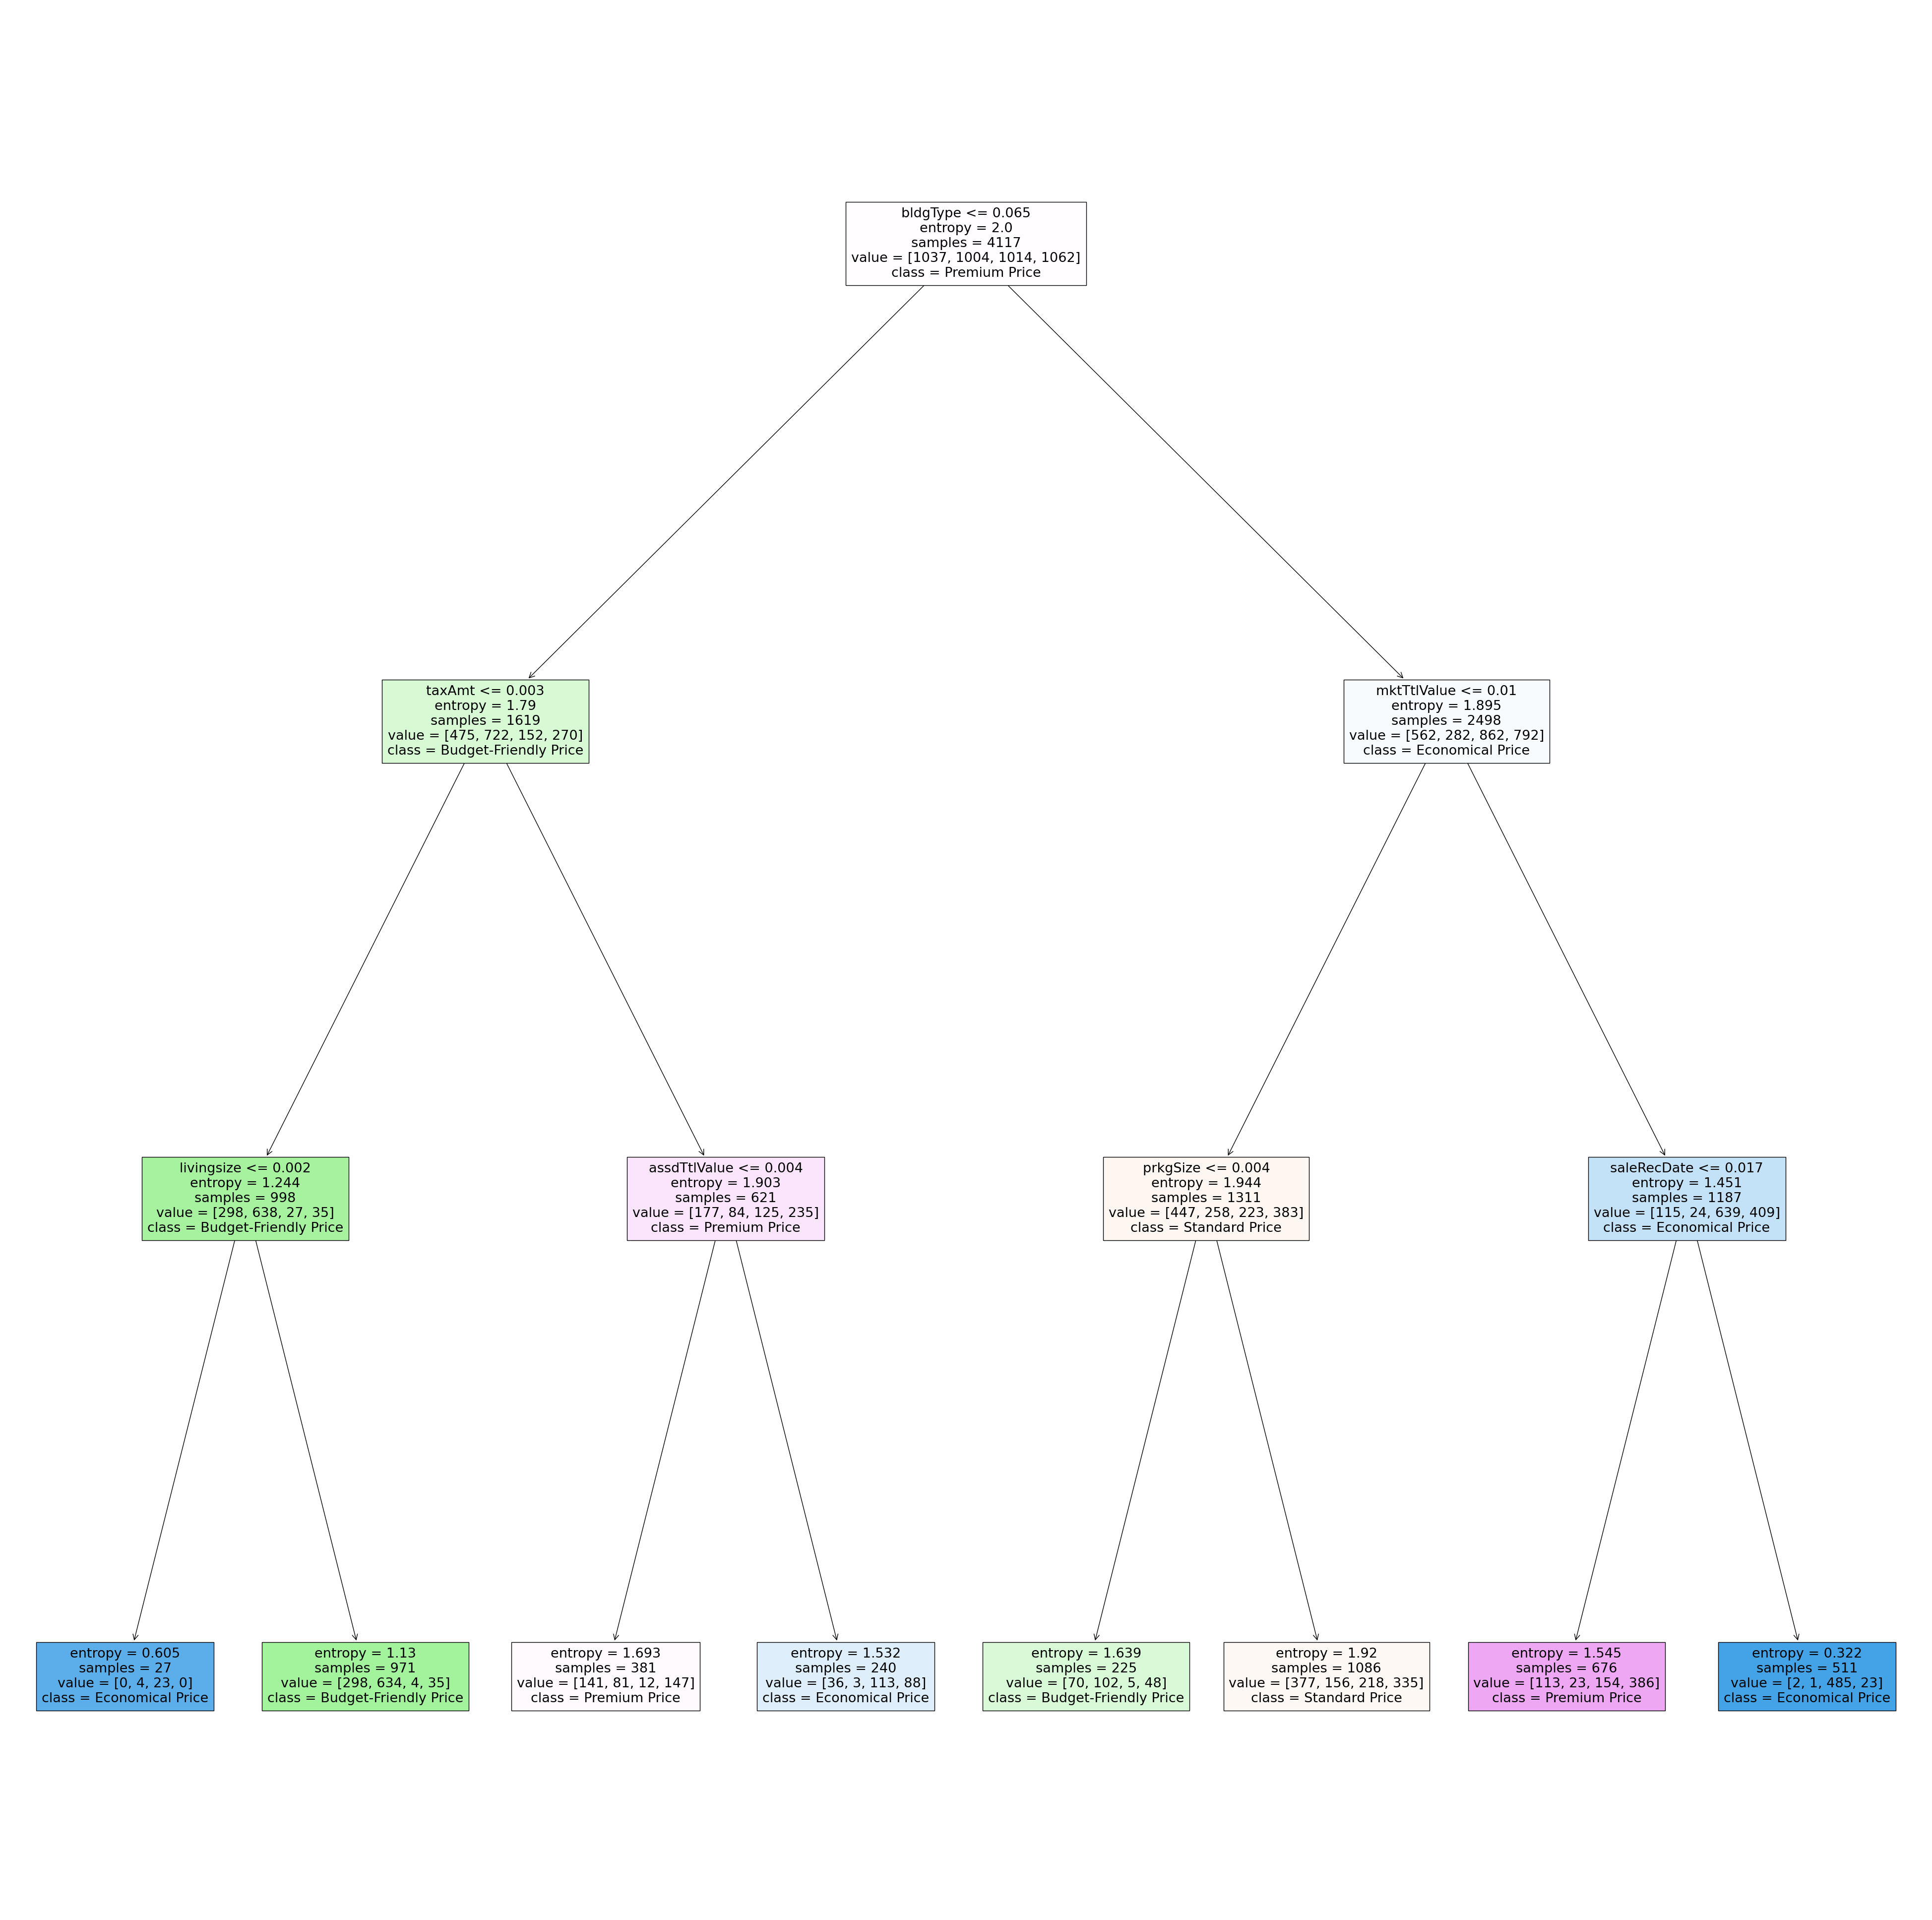

In [40]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (50, 50), dpi=100)
plot_tree(DT3, filled=True, feature_names=feature_names, class_names=class_names, impurity=True, ax=axes)

[[ 86  87  12  64]
 [ 43 198   2  38]
 [ 63   0 170  43]
 [ 64  21  21 118]]
Accuracy of tree with entropy as criterion, max_depth=4, max_features=4, min_samples_leaf=2, min_samples_split=3 is: 0.5553398058252427


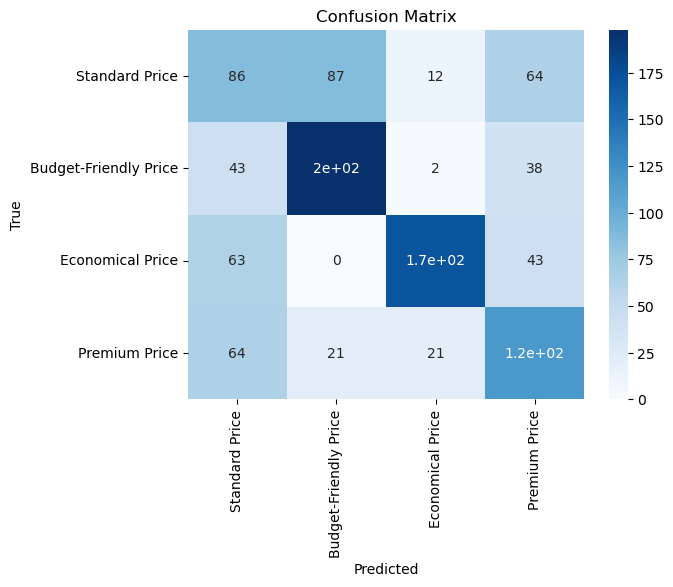

In [41]:
# Use the classifier to make predictions on the testing data
y_pred_3 = DT3.predict(X_test)

# Get the confusion matrix
cm_3 = confusion_matrix(y_test, y_pred_3)
print(cm_3)

# Print the confusion matrix
sns.heatmap(cm_3, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Get and Print the accuracy
accuracy_3 = accuracy_score(y_test, y_pred_3)
print("Accuracy of tree with entropy as criterion, max_depth=4, max_features=4, min_samples_leaf=2, min_samples_split=3 is: " + str(accuracy_3))

### Multinomial Naive Bayes

In [42]:
multinomial_nb = MultinomialNB()

In [43]:
multinomial_nb.fit(X_train, y_train)

MultinomialNB()

In [44]:
y_pred_multinomial_nb = multinomial_nb.predict(X_test)

In [46]:
accuracy_multinomial_nb = accuracy_score(y_test, y_pred_multinomial_nb)
cm_multinomial_nb = confusion_matrix(y_test, y_pred_multinomial_nb)
print(cm_multinomial_nb)

[[ 21  44   7 177]
 [ 26 140  11 104]
 [  0   9  78 189]
 [  3  11  16 194]]


Accuracy of Multinomial Naive Bayes: 0.4203883495145631


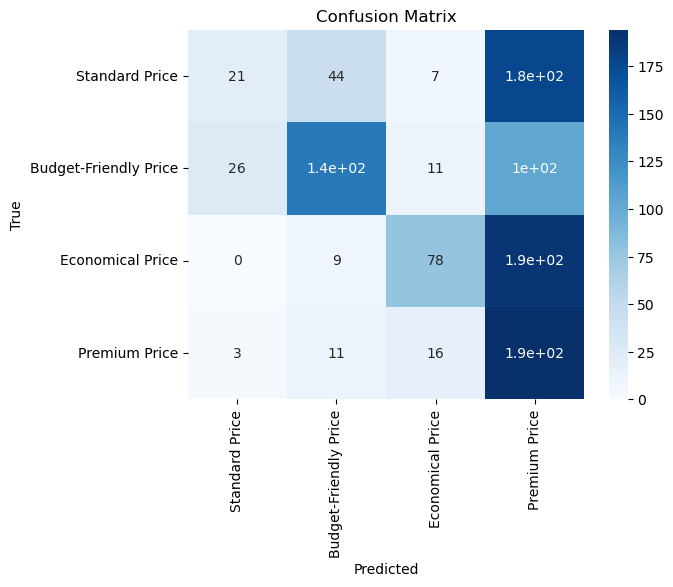

In [47]:
# Print the confusion matrix
sns.heatmap(cm_multinomial_nb, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


print("Accuracy of Multinomial Naive Bayes: " + str(accuracy_multinomial_nb))

### Bernoulli Naive Bayes

In [48]:
bernoulli_nb = BernoulliNB()

In [49]:
bernoulli_nb.fit(X_train, y_train)

BernoulliNB()

In [50]:
y_pred_bernoulli_nb = bernoulli_nb.predict(X_test)

In [52]:
accuracy_bernoulli_nb = accuracy_score(y_test, y_pred_bernoulli_nb)
cm_bernoulli_nb = confusion_matrix(y_test, y_pred_bernoulli_nb)
print(cm_bernoulli_nb)

[[ 16  98 101  34]
 [ 14 203  48  16]
 [  4  12 226  34]
 [  5  51 140  28]]


Accuracy of Bernoulli Naive Bayes: 0.45922330097087377


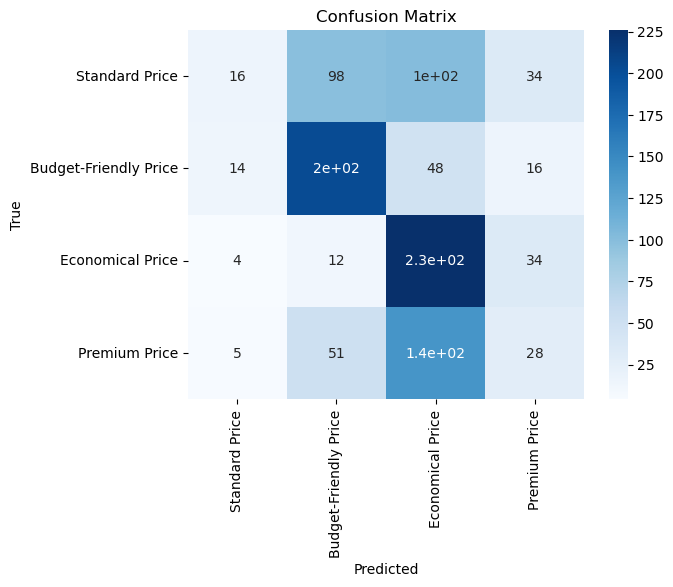

In [53]:
# Print the confusion matrix
sns.heatmap(cm_bernoulli_nb, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


print("Accuracy of Bernoulli Naive Bayes: " + str(accuracy_bernoulli_nb))

### Gaussian Naive Bayes

In [54]:
gaussian_NB = GaussianNB()

In [55]:
gaussian_NB.fit(X_train, y_train)

GaussianNB()

In [56]:
y_pred_gaussian_nb = gaussian_NB.predict(X_test)

In [57]:
accuracy_gaussian_nb = accuracy_score(y_test, y_pred_gaussian_nb)
cm_gaussian_nb = confusion_matrix(y_test, y_pred_gaussian_nb)
print(cm_gaussian_nb)

[[ 30  27   2 190]
 [ 65  86   1 129]
 [ 31   8  43 194]
 [  6   7   6 205]]


Accuracy of Gaussian Naive Bayes: 0.3533980582524272


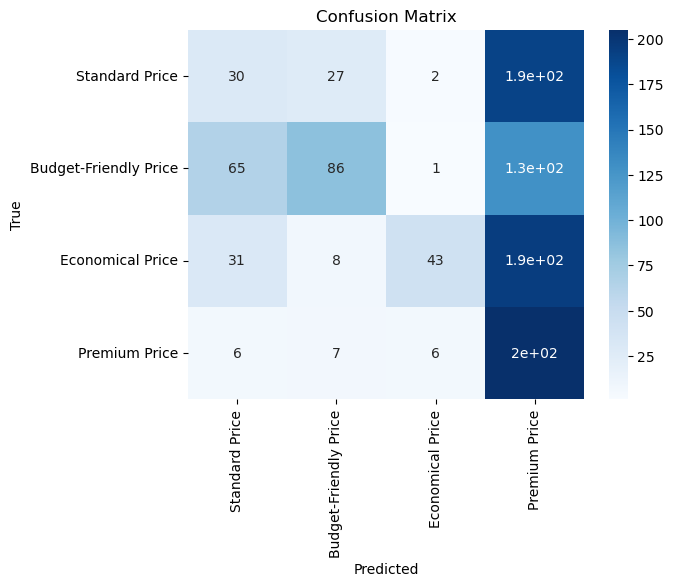

In [59]:
sns.heatmap(cm_gaussian_nb, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


print("Accuracy of Gaussian Naive Bayes: " + str(accuracy_gaussian_nb))